<a href="https://colab.research.google.com/github/Jersae/Google-TimeSeries-workshop/blob/main/(Chee_Wee)TSSD_3_Simple_models_code_along_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Simple Models Code along

- Dense Model  
- Conv1D Model  
- LSTM Model  

### Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, GlobalAveragePooling1D, LSTM, Dropout

## Getting the data

M4 dataset

https://www.kaggle.com/yogesh94/m4-forecasting-competition-dataset

In [2]:
!wget -q https://www.dropbox.com/s/vtvrem02pby4hhp/m4_dataset.zip
!unzip -q m4_dataset.zip

In [3]:
ls

Daily-test.csv    m4_dataset.zip     Quarterly-test.csv   Weekly-train.csv
Daily-train.csv   m4_info.csv        Quarterly-train.csv  Yearly-test.csv
Hourly-test.csv   Monthly-test.csv   sample_data/         Yearly-train.csv
Hourly-train.csv  Monthly-train.csv  Weekly-test.csv


In [4]:
days = pd.read_csv('./Daily-train.csv')

In [5]:
days.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V9881,V9882,V9883,V9884,V9885,V9886,V9887,V9888,V9889,V9890,V9891,V9892,V9893,V9894,V9895,V9896,V9897,V9898,V9899,V9900,V9901,V9902,V9903,V9904,V9905,V9906,V9907,V9908,V9909,V9910,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
0,D1,1017.10,1019.30,1017.00,1019.20,1018.70,1015.60,1018.50,1018.30,1018.4,1021.50,1023.00,1023.30,1020.50,1021.40,1018.10,1022.60,1022.60,1021.00,1020.10,1017.00,1019.3,1017.30,1016.10,1017.80,1019.30,1025.10,1024.80,1025.10,1025.10,1022.60,1021.20,1017.20,1041.50,1041.70,1038.90,1041.00,1042.90,1042.10,1043.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D2,2793.70,2793.80,2803.70,2805.80,2802.30,2795.00,2806.40,2782.20,2780.3,2781.40,2768.40,2779.00,2774.90,2770.00,2780.00,2752.30,2749.90,2748.40,2744.30,2757.30,2754.8,2752.50,2743.80,2763.70,2756.60,2756.30,2767.70,2771.70,2774.90,2770.20,2768.40,2759.20,2760.30,2746.00,2738.50,2713.60,2705.10,2701.80,2706.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D3,1091.30,1088.50,1085.70,1082.90,1080.10,1077.30,1074.50,1071.70,1068.9,1066.10,1063.30,1060.50,1057.70,1054.90,1052.10,1049.30,1046.50,1043.70,1040.90,1038.10,1035.3,1032.50,1029.70,1025.50,1022.70,1019.90,1017.10,1014.30,1011.50,1008.70,1005.90,1003.10,1000.30,997.50,994.70,991.90,989.10,986.30,983.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D4,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1008.00,1092.00,1078.0,1064.00,1050.00,1036.00,1022.00,1092.00,1079.00,1064.00,1050.00,1036.00,1022.00,1092.00,1078.0,1064.00,1092.00,1078.00,1065.00,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1092.00,1078.00,1064.00,1050.00,1092.00,1078.00,1064.00,1050.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D5,2938.63,2956.44,2964.41,2972.41,3014.97,3014.23,3024.08,3031.97,3062.7,3057.19,3063.93,3068.45,3072.98,3431.69,3436.86,3441.45,3446.05,3454.46,3459.42,3463.44,3467.3,3485.64,3475.19,3478.89,3482.34,3486.01,4087.11,4092.18,4096.39,4100.62,4106.51,4111.35,4115.66,4119.77,4139.93,4130.28,4135.06,4139.71,4145.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


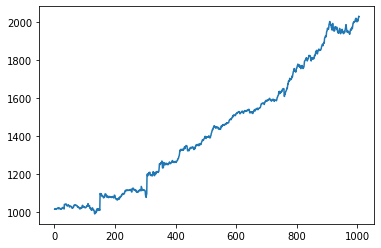

In [6]:
single_day = days.loc[0].transpose()
df = pd.DataFrame(single_day).reset_index().drop([0])

df[0].plot()

In [7]:
df = df.drop(['index'], axis =1)
df.columns = ['values']

#Take first 1000 data
df = df[:1000]

## Formating the data



In [8]:
#Convert to numpy
timesteps = np.array(df.index)
values = df['values'].to_numpy()

timesteps.shape, values.shape

((1000,), (1000,))

In [11]:
#make a train test split
split = int(len(values) * 0.8)

X_train, y_train = timesteps[:split], values[:split]
X_test, y_test = timesteps[split:], values[split:]

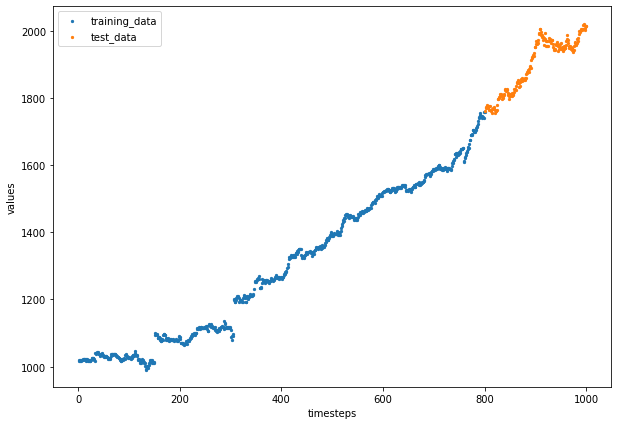

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

## Setting up a data loader


In [26]:
window_size = 10

def create_dataset(values, window_size):
  #dataset = tf.data.Dataset.from_tensor_slices(tf.constant(values, tf.float32))
  dataset = tf.expand_dims(tf.constant(values, tf.float32), axis=1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset


In [14]:
train_dataset = create_dataset(y_train, window_size = 10)
test_dataset = create_dataset(y_test, window_size = 10)

In [28]:
train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>)

## Model 1 Dense model

In [29]:
# Dense model

Inp = Input(shape=[window_size,1], name='Inp')
x = Flatten()(Inp)
x = Dense(128, activation='relu',name='Dense_01')(x)
#x = Dense(128, activation='relu',name='Dense_02')(x)
#x = Dense(128, activation='relu',name='Dense_03')(x)
outputs = Dense(1, name='Outputs')(x)

Tried:
1. Batch Normalisation - Performance much worse
2. Dropout - performance dropped
3. Extra Dense Layer - Performnance Dropped
4. Reduce to one dense layer - Performace improved

In [91]:
model_dense = tf.keras.Model(Inp, outputs, name='baseline_dense')

In [92]:
model_dense.summary()

Model: "baseline_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 1)]         0         
_________________________________________________________________
Conv1d_01 (Conv1D)           (None, None, 64)          384       
_________________________________________________________________
GlobalPolling (GlobalAverage (None, 64)                0         
_________________________________________________________________
Outputs (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [93]:
model_dense.compile(loss='mae', optimizer='Adam', metrics=['mae'])

In [95]:
model_dense.fit(train_dataset, epochs=20)

Epoch 1/20
25/25 [==============================] - 0s 4ms/step - loss: 10.6881 - mae: 10.6881
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 8.9171 - mae: 8.9171
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 10.6731 - mae: 10.6731
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 10.6199 - mae: 10.6199
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 9.7222 - mae: 9.7222
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 10.4490 - mae: 10.4490
Epoch 7/20
25/25 [==============================] - 0s 5ms/step - loss: 10.7649 - mae: 10.7649
Epoch 8/20
25/25 [==============================] - 0s 5ms/step - loss: 10.3815 - mae: 10.3815
Epoch 9/20
25/25 [==============================] - 0s 5ms/step - loss: 10.8253 - mae: 10.8253
Epoch 10/20
25/25 [==============================] - 0s 5ms/step - loss: 10.0830 - mae: 10.0830
Epoch 11/20
25/25 [==============================] - 

In [96]:
model_dense.evaluate(test_dataset)

6/6 [==============================] - 0s 7ms/step - loss: 14.6197 - mae: 14.6197


[14.619673728942871, 14.619673728942871]

In [97]:
dense_preds = tf.squeeze(model_dense.predict(test_dataset))
dense_preds.shape

TensorShape([190])

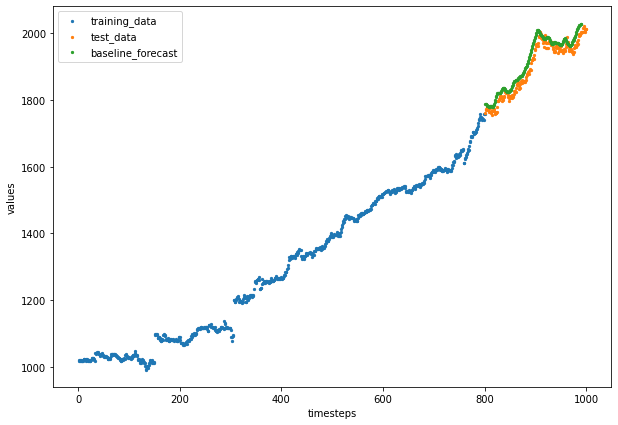

In [98]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.scatter(X_test[:-10], dense_preds,s=5, label='baseline_forecast') # we minus 10 becuase that is the window size

plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

## Model 2 - Conv1D

In [99]:
# conv1D model
Inp = Input(shape=[None,1],name='Input')
x = Conv1D(64, kernel_size=5, activation='relu', name='Conv1d_01')(Inp)
x= GlobalAveragePooling1D(name='GlobalPolling')(x)
outputs = Dense(1, name='Outputs')(x)

In [100]:
model_conv = tf.keras.Model(Inp, outputs, name='Baseline_conv')

In [101]:
model_conv.summary()

Model: "Baseline_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 1)]         0         
_________________________________________________________________
Conv1d_01 (Conv1D)           (None, None, 64)          384       
_________________________________________________________________
GlobalPolling (GlobalAverage (None, 64)                0         
_________________________________________________________________
Outputs (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [103]:
model_conv.compile(loss='mae', optimizer='Adam', metrics=['mae'])

In [104]:
#train the model
es = tf.keras.callbacks.EarlyStopping(monitor='mae', mode='auto', restore_best_weights=True)
model_conv.fit(train_dataset, epochs=20, callbacks=[es])

Epoch 1/20
25/25 [==============================] - 0s 5ms/step - loss: 789.1412 - mae: 789.1412
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 108.0453 - mae: 108.0453
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 24.2551 - mae: 24.2551
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 10.1505 - mae: 10.1505
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 9.0392 - mae: 9.0392
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 9.6113 - mae: 9.6113


Implemented early stopping callbacks as i see that mae increases in the midst of training. 

In [105]:
model_conv.evaluate(test_dataset)

6/6 [==============================] - 0s 7ms/step - loss: 13.5058 - mae: 13.5058


[13.505838394165039, 13.505838394165039]

In [106]:
# predict
conv_preds = tf.squeeze(model_conv.predict(test_dataset))
conv_preds.shape

TensorShape([190])

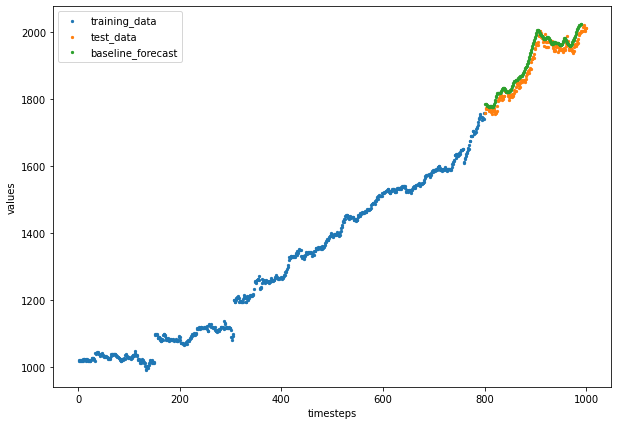

In [107]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.scatter(X_test[:-10], conv_preds,s=5, label='baseline_forecast') # we minus 10 becuase that is the window size

plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

## Model 3 LSTM

In [245]:
# LSTM model model
Inp = Input(shape=[None, 1], name='Inputs')
x = LSTM(32, return_sequences=True, activation='relu', name='LSTM_01')(Inp)
#x= Dropout(0.1)(x)
x = LSTM(64, return_sequences=False, activation='relu', name='LSTM_02')(x)
outputs = Dense(1, name='Output')(x)

Tried:
1. Drop out, does not improve
2. Using 1 layer gives higher loss
3. Adding additional layer gives similar results
4. Increasing epochs does nothelp as loss saturate
5. Callbacks do not help in this case as loss fluctuates at start of training
6. Chaning activation to tanh makes it worse

In [246]:
model_lstm = tf.keras.Model(Inp, outputs, name='baseline_lstm')

In [247]:
model_lstm.compile(loss='mae', optimizer='adam',metrics=['mae','mape'])

In [237]:
model_lstm.summary()

Model: "baseline_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, None, 1)]         0         
_________________________________________________________________
LSTM_01 (LSTM)               (None, None, 64)          16896     
_________________________________________________________________
LSTM_02 (LSTM)               (None, 32)                12416     
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [248]:
# train the model
es = tf.keras.callbacks.EarlyStopping(monitor='mape', mode='auto', restore_best_weights=True)
model_lstm.fit(train_dataset, epochs=20)

Epoch 1/20
25/25 [==============================] - 2s 31ms/step - loss: 353.2119 - mae: 353.2119 - mape: 33.5098
Epoch 2/20
25/25 [==============================] - 1s 31ms/step - loss: 16.6336 - mae: 16.6336 - mape: 1.4596
Epoch 3/20
25/25 [==============================] - 1s 32ms/step - loss: 11.1035 - mae: 11.1035 - mape: 0.9882
Epoch 4/20
25/25 [==============================] - 1s 31ms/step - loss: 14.4170 - mae: 14.4170 - mape: 1.2782
Epoch 5/20
25/25 [==============================] - 1s 31ms/step - loss: 17.6268 - mae: 17.6268 - mape: 1.5727
Epoch 6/20
25/25 [==============================] - 1s 33ms/step - loss: 16.5889 - mae: 16.5889 - mape: 1.5191
Epoch 7/20
25/25 [==============================] - 1s 30ms/step - loss: 13.1682 - mae: 13.1682 - mape: 1.1572
Epoch 8/20
25/25 [==============================] - 1s 30ms/step - loss: 15.1201 - mae: 15.1201 - mape: 1.3346
Epoch 9/20
25/25 [==============================] - 1s 30ms/step - loss: 15.1368 - mae: 15.1368 - mape: 1.350

In [252]:
model_lstm.evaluate(test_dataset)

6/6 [==============================] - 0s 7ms/step - loss: 15.7778 - mae: 15.7778 - mape: 0.8276


[15.777775764465332, 15.777775764465332, 0.8275585174560547]

In [250]:
lstm_preds = tf.squeeze(model_lstm.predict(test_dataset))
lstm_preds.shape

TensorShape([190])

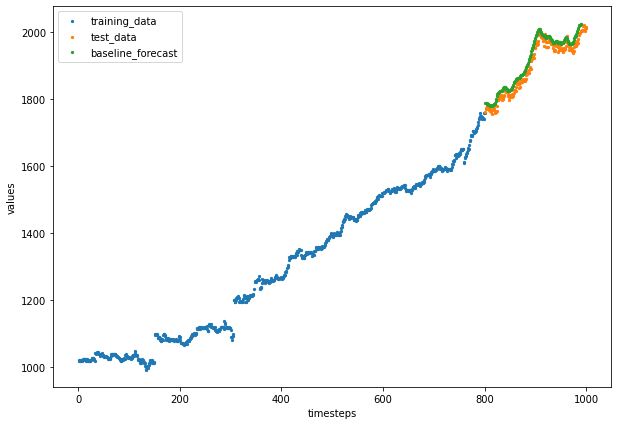

In [251]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.scatter(X_test[:-10], lstm_preds,s=5, label='baseline_forecast') # we minus 10 becuase that is the window size

plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

In [155]:
## Add in comparing on different Loss functions
def evaluate_metrics(y_true, y_preds, use_window=True, window_size=10):
  if use_window:
    y_true = y_true[window_size:]

  #convert to tf tensors
  y_true = tf.constant(y_true, tf.float32)
  y_preds = tf.constant(y_preds, tf.float32)

  #calculate loss metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_preds)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_preds)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_preds)

  return {"mae": mae.numpy(), "mse": mse.numpy(), "mape": mape.numpy()}

In [156]:
evaluate_metrics(y_test, dense_preds)

{'mae': 14.619674, 'mape': 0.76835173, 'mse': 325.45706}

In [157]:
evaluate_metrics(y_test, conv_preds)

{'mae': 13.505838, 'mape': 0.70929027, 'mse': 272.5939}

In [253]:
evaluate_metrics(y_test, lstm_preds)

{'mae': 15.777776, 'mape': 0.8275585, 'mse': 357.6522}